# Colab Setup & Download Data

This report seeks to predict whether an X-ray image represents COVID-19, viral pneumonia, or is normal. Find this project on github here: https://github.com/TheStreett/COVIDxrays

Data Source: <br> 
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

In [2]:
# Colab Setup 

!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [4]:

# Download and unzip data
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip


Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/COVID-19_Radiography_Database.zip
1.22GB [00:09, 128MB/s] 
Archive:  COVID-19_Radiography_Database.zip
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
   creating: COVID-19 Radiography Database/COVID/
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1005).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1006).png  
  inflati

# Data Description

This dataset contains chest x-ray images of COVID-19 positive cases, normal cases, and viral pneumonia cases. There are 1200 COVID-19 positive images, 1341 normal images and 1345 viral pneuomonia images.

A model that can take an xray image and predict whether or not someone has COVID can be used in several ways. For example, models may be able to help to identify patterns in COVID cases earlier and more regularly, potentially reducing the number of severe cases. 

It's not advisable to have computer-generated models replace the skill of trained doctors for diagnosing COVID, but perhaps models could alleviate stress on hospital systems by helping to determine which cases should be highest priority for a doctor's attention, or for adding one more diagnostic confirmation along the way. 

In [5]:
# Preprocess Images
def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath. ## into rar matrix data 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, shape) # Change height and width of image. 
        img = img / 255.0 # Min-max transform. 


        # Resize the images.
        X = np.array(img)
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime. 
        return X


In [6]:
# Extracting all filenames iteratively
base_path = '/content/COVID-19 Radiography Database' #set up directory
categories = ['COVID', 'NORMAL', 'Viral Pneumonia'] # list of sub-folder names

# load file names to fnames list object
fnames = []
for category in categories:
    cat_folder = os.path.join(base_path, category)
    file_names = os.listdir(cat_folder) 
    full_path = [os.path.join(cat_folder, file_name) for file_name in file_names] 
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [1200, 1341, 1345]


In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
xray_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data
preprocessed_image_data=list(map(preprocessor,xray_filepaths ))

# Object needs to be an array rather than a list for Keras 
X= np.array(preprocessed_image_data)

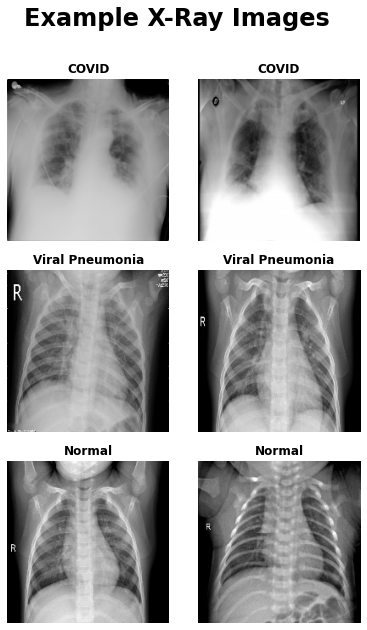

In [8]:
# Display images from each category
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('/content/COVID-19 Radiography Database/COVID/COVID (1).png')
im2 =preprocessor('/content/COVID-19 Radiography Database/COVID/COVID (10).png')
im3 =preprocessor('/content/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')
im4 =preprocessor('/content/COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')
im5 =preprocessor('/content/COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im6 =preprocessor('/content/COVID-19 Radiography Database/NORMAL/NORMAL (1003).png')

fig = plt.figure(figsize=(8., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.4, 
                 )

titles = ["COVID", "COVID", "Viral Pneumonia", "Viral Pneumonia", "Normal", "Normal"]

for ax, im, title in zip(grid, [im1, im2, im3, im4, im5, im6], titles):
    # Iterating over the grid returns the Axes.
    ax.set_title(title, fontdict=None, loc='center', color = "k", fontweight="bold")
    ax.imshow(im)
    ax.axis('off')
main_title = 'Example X-Ray Images'
plt.suptitle(main_title, fontsize=24, fontweight='bold')
plt.show()

# Train/Test/Split

In [37]:
# Y Labels: 
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
viral_p=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+viral_p

#check length
len(y_labels) == len(X)

# One Hot Encode
import pandas as pd
y=pd.get_dummies(y_labels)

number of images for each category: [1200, 1341, 1345]


In [38]:
# Train test split resized images
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


#Split training data to create validation set
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.20, random_state = 1987)

# Models 1a + 1b: Baseline Models (No Convolution)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(3, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(Xb_train, yb_train, 
                    epochs = 25, verbose=1,validation_data=(Xb_test,yb_test))

Epoch 1/25
78/78 [==============================] - 194s 2s/step - loss: 1.0681 - accuracy: 0.5440 - val_loss: 0.5155 - val_accuracy: 0.7508
Epoch 2/25
78/78 [==============================] - 194s 2s/step - loss: 0.4445 - accuracy: 0.8211 - val_loss: 0.3478 - val_accuracy: 0.8778
Epoch 3/25
78/78 [==============================] - 193s 2s/step - loss: 0.3714 - accuracy: 0.8570 - val_loss: 0.3015 - val_accuracy: 0.8923
Epoch 4/25
78/78 [==============================] - 192s 2s/step - loss: 0.3116 - accuracy: 0.8889 - val_loss: 0.3001 - val_accuracy: 0.8875
Epoch 5/25
78/78 [==============================] - 193s 2s/step - loss: 0.2994 - accuracy: 0.8914 - val_loss: 0.3384 - val_accuracy: 0.8601
Epoch 6/25
78/78 [==============================] - 192s 2s/step - loss: 0.2834 - accuracy: 0.8950 - val_loss: 0.3137 - val_accuracy: 0.8826
Epoch 7/25
78/78 [==============================] - 191s 2s/step - loss: 0.2932 - accuracy: 0.8939 - val_loss: 0.2377 - val_accuracy: 0.9100
Epoch 8/25
78

In [ ]:
# Evaluate
prediction_index=predict_classes(model.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

['Viral Pneumonia', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'COVID', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'NORMAL', 'COVID', 'Viral Pneumonia', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'COVID', 'Viral Pneumonia', 'COVID', 'NORMAL', 'Viral Pneumonia', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID',

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.917738,0.918983,0.924552,0.916951,0,0,0,0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(32, activation='relu'))
      model.add(Dense(24, activation='relu'))
      model.add(Flatten())
      model.add(Dense(3, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(Xb_train, yb_train, 
                    epochs = 25, verbose=1,validation_data=(Xb_test,yb_test))

Epoch 1/25
78/78 [==============================] - 170s 2s/step - loss: 0.8637 - accuracy: 0.5671 - val_loss: 0.5067 - val_accuracy: 0.7765
Epoch 2/25
78/78 [==============================] - 170s 2s/step - loss: 0.4811 - accuracy: 0.8243 - val_loss: 0.3665 - val_accuracy: 0.8617
Epoch 3/25
78/78 [==============================] - 170s 2s/step - loss: 0.4145 - accuracy: 0.8279 - val_loss: 0.5399 - val_accuracy: 0.7379
Epoch 4/25
78/78 [==============================] - 171s 2s/step - loss: 0.3935 - accuracy: 0.8345 - val_loss: 0.2873 - val_accuracy: 0.8955
Epoch 5/25
78/78 [==============================] - 170s 2s/step - loss: 0.3095 - accuracy: 0.8887 - val_loss: 0.2760 - val_accuracy: 0.8987
Epoch 6/25
78/78 [==============================] - 170s 2s/step - loss: 0.2945 - accuracy: 0.8887 - val_loss: 0.2662 - val_accuracy: 0.8987
Epoch 7/25
78/78 [==============================] - 171s 2s/step - loss: 0.2595 - accuracy: 0.9091 - val_loss: 0.3169 - val_accuracy: 0.8762
Epoch 8/25
78

In [ ]:
# Evaluate
prediction_index=predict_classes(model.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

['Viral Pneumonia', 'NORMAL', 'COVID', 'NORMAL', 'Viral Pneumonia', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'COVID', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'COVID', 'NORMAL', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'Viral Pneumonia', 'NORMAL', 'COVID', 'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'COVID', 'Viral Pneumonia', 'COVID', 'COVID', 'Viral Pneumonia', 'COVID', 'NORMAL', 'Viral Pneumonia', 'COVID', 'COVID', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'Viral Pneumonia', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'NORMAL', 'Viral Pneumonia', 'Viral Pneumonia', 'COVID', 'Viral Pneumonia', 'NORMAL', 'NORMAL', 'NORMAL'

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.929306,0.930146,0.9312,0.93005,0,0,0,0


# Model 2: Adding CNNs

In [21]:
from keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_3 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=24, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=24, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #slow down learning process: 
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.1) 

  model_3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  mc = ModelCheckpoint('model_3', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
  
  # Fitting the CNN to the Training set
  model_3.fit(Xb_train, yb_train, 
                    epochs = 25, verbose=1,validation_data=(Xb_test,yb_test), callbacks=[red_lr, mc]) 

Train on 2486 samples, validate on 622 samples
Epoch 1/25
2464/2486 [============================>.] - ETA: 1s - loss: 0.7382 - acc: 0.6360
Epoch 00001: val_acc improved from -inf to 0.85209, saving model to model_3
2486/2486 [==============================] - 163s 65ms/sample - loss: 0.7363 - acc: 0.6368 - val_loss: 0.3859 - val_acc: 0.8521
Epoch 2/25
2464/2486 [============================>.] - ETA: 1s - loss: 0.3254 - acc: 0.8734
Epoch 00002: val_acc improved from 0.85209 to 0.87299, saving model to model_3
2486/2486 [==============================] - 159s 64ms/sample - loss: 0.3255 - acc: 0.8733 - val_loss: 0.3419 - val_acc: 0.8730
Epoch 3/25
2464/2486 [============================>.] - ETA: 1s - loss: 0.2473 - acc: 0.9144
Epoch 00003: val_acc improved from 0.87299 to 0.91318, saving model to model_3
2486/2486 [==============================] - 158s 64ms/sample - loss: 0.2491 - acc: 0.9139 - val_loss: 0.2600 - val_acc: 0.9132
Epoch 4/25
2464/2486 [============================>.] - 

In [17]:
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [39]:
# get y_test lables from a one_hot_encoded object
y_test_labels=y_test.idxmax(axis=1)
y_test_labels=list(y_test.idxmax(axis=1)) 

In [40]:
# Evaluate
prediction_index=predict_classes(model_3.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.960154,0.96074,0.960445,0.961287,0,0,0,0


# Model 3: Inception_Resnet


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
219062272/219055592 [==============================] - 4s 0us/step


In [ ]:
# Freeze most layers

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=5

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  780
Number of layers frozen in the base model:  775


In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model_3 = Model(inputs=base_model.inputs, outputs=output)
# summarize
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 95, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_3.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  mc = ModelCheckpoint('model_3', monitor='val_acc',mode='max', verbose=1, save_best_only=True)
  

  model_3.fit(Xb_train, yb_train,
          epochs = 12, verbose=1,validation_data=(Xb_test,yb_test), callbacks=[mc])
  

Train on 2486 samples, validate on 622 samples
Epoch 1/12
2464/2486 [============================>.] - ETA: 14s - loss: 0.3601 - acc: 0.8994
Epoch 00001: val_acc improved from -inf to 0.60772, saving model to model_3
2486/2486 [==============================] - 1735s 698ms/sample - loss: 0.3593 - acc: 0.9002 - val_loss: 1.4863 - val_acc: 0.6077
Epoch 2/12
2464/2486 [============================>.] - ETA: 14s - loss: 0.3122 - acc: 0.9026
Epoch 00002: val_acc improved from 0.60772 to 0.70900, saving model to model_3
2486/2486 [==============================] - 1712s 689ms/sample - loss: 0.3146 - acc: 0.9010 - val_loss: 0.9498 - val_acc: 0.7090
Epoch 3/12
2464/2486 [============================>.] - ETA: 14s - loss: 0.2872 - acc: 0.9079
Epoch 00003: val_acc did not improve from 0.70900
2486/2486 [==============================] - 1707s 687ms/sample - loss: 0.2870 - acc: 0.9075 - val_loss: 1.3823 - val_acc: 0.6495
Epoch 4/12
2464/2486 [============================>.] - ETA: 13s - loss: 0.2

^ This model stopped early, but with validation accuracy rates around 65-73%, it clearly wasn't about to perform better than the previous models, even with several  more epochs. This model had a significant overfitting problem, so it might perform better with slower learning rates, more data, and a much higher number of epochs.

# Model 4: Xception Model

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model_X = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
# Freeze most layers

print("Number of layers in the base model: ", len(base_model_X.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=5

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model_X.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model_X.layers)-freeze_layers_after)

Number of layers in the base model:  132
Number of layers frozen in the base model:  127


In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model_X.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model_4 = Model(inputs=base_model_X.inputs, outputs=output)
# summarize
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_4.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
# save best model given maximum val_accuracy, stop early if loss does not improve after 5 further iterations beyond best loss
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization

  model_4.fit(Xb_train, yb_train,
          epochs = 25, verbose=1,validation_data=(Xb_test,yb_test), callbacks=[es,mc])

Epoch 1/25
78/78 [==============================] - 1135s 15s/step - loss: 0.4913 - accuracy: 0.8122 - val_loss: 0.3172 - val_accuracy: 0.8955

Epoch 00001: val_accuracy improved from -inf to 0.89550, saving model to best_model.h5
Epoch 2/25
78/78 [==============================] - 1140s 15s/step - loss: 0.1969 - accuracy: 0.9327 - val_loss: 0.3037 - val_accuracy: 0.9035

Epoch 00002: val_accuracy improved from 0.89550 to 0.90354, saving model to best_model.h5
Epoch 3/25
78/78 [==============================] - 1143s 15s/step - loss: 0.1377 - accuracy: 0.9572 - val_loss: 0.2363 - val_accuracy: 0.9260

Epoch 00003: val_accuracy improved from 0.90354 to 0.92605, saving model to best_model.h5
Epoch 4/25
78/78 [==============================] - 1137s 15s/step - loss: 0.1323 - accuracy: 0.9544 - val_loss: 0.2694 - val_accuracy: 0.9196

Epoch 00004: val_accuracy did not improve from 0.92605
Epoch 5/25
78/78 [==============================] - 1136s 15s/step - loss: 0.1345 - accuracy: 0.9548 -

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model_4.predict(X_test)))

prediction_index=predict_classes(model_4.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 2 2 2 2 1 0 2 2 2 1 1 2 2 0 2 1 2 0 2
 1 0 2 2 0 2 0 1 2 0 0 2 1 2 1 0 1 1 1 1 0 2 2 1 0 0 2 1 1 2 1 2 1 2 2 0 2
 1 1 1 2 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 1 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 2 1 0 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 0 2 1 1 0
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 2 0 1 0 2 0 2 1 2 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 2 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 2 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 0 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 2 2 2 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 2 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 2 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 2 1 0 1 0 2 1 0 2 

In [ ]:
# get y_test lables from a one_hot_encoded object
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test objects


3235    Viral Pneumonia
2083             NORMAL
1041              COVID
1781             NORMAL
3070    Viral Pneumonia
             ...       
3139    Viral Pneumonia
3426    Viral Pneumonia
1846             NORMAL
811               COVID
3220    Viral Pneumonia
Length: 778, dtype: object

In [ ]:
# get metrics
model_eval_metrics(y_test_labels, predicted_labels, classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.939589,0.940765,0.942921,0.940861,0,0,0,0


# Discussion

I was surprised that my Transfer Learning models were not more competitive in this scenario, and how much time was a limiting factor in being able to fine-tune them. <br><br>
The Xception model (93.9% accuracy) might have been more competitive if I had trained it towards the validation accuracy of the original Train/Test/Split. However, I chose not to do that for any of my models, and to instead do a secondary Train/Test/Split of my training data so that the models wouldn't be artificially trained towards this particular split of the data. <br><br>
If I had unlimited time and computing power, I would have done cross-validation throughout my models to ensure that the models were robust to however the dataset was split. Since that wasn't a viable option for this assignment, I did the next "best" thing by also splitting my training data. 
<br><br>
The worst performing model was the Inception_Resnet (70.9% accuracy), which had a signficant overfitting problem (not surprising, given that it had over 750 layers and only had a couple thousand images to learn from). It might have performed better with slower learning rates and higher epochs, but without a significant increase in the amount of data, it was still likely to overfit. <br><br>
The best performing model was the "simple" keras sequential model with convolutional layers. With unlimited time & computing power, I would have continued to fine-tune this model to see how much higher I could push the accuracy - Including fine-tuning the number of layers, number of filters, number of epochs, and kernel size. The best model had 13 convolutional layers with 4 max pooling layers spread throughout. As of the time of submission, it ranks 18 out of 56 models on the leaderboard.  
<br><br>
My next steps for further research would be to fine-tune the parameters on both the Sequential model and the Xception model, to continue to see how high I could push the accuracy. 



# AI Modelshare Leaderboard

In [ ]:
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [12]:
from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

Using TensorFlow backend.


AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [44]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [15]:
ai.export_preprocessor(preprocessor,"") 

In [42]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model_3, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 76 -> 36


In [45]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 60'

In [46]:
# Get Leaderboard
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.992288,0.992486,0.992412,0.992565,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers': [{'name': 'inpu...",dv2438,2021-03-07 23:02:41.978914,45
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
2,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
3,0.983290,0.983636,0.983446,0.983891,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:43:34.857578,48
4,0.980720,0.981091,0.981226,0.981263,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:06:55.748014,26
5,0.979434,0.979710,0.979604,0.980173,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': [{'name': 'input...",prajseth,2021-03-08 02:34:38.630185,50
6,0.978149,0.978550,0.978470,0.978635,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:50:31.207727,49
7,0.975578,0.976001,0.975782,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:39:11.372915,47
8,0.975578,0.976024,0.975700,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:55:54.375970,40
9,0.970437,0.971197,0.971771,0.970751,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 21:57:59.450067,22


In [ ]:
#Stylize Leaderboard
ai.stylize_leaderboard(data,category="classification")